In [1]:
from pruneshift.networks import create_network
from pruneshift.utils import load_pruned_state_dict, load_state_dict
from pruneshift.prune_info import PruneInfo
from pruneshift.prune_hydra import hydrate
from pruneshift.prune import prune
from itertools import chain
from functools import partial
import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt
import os
from pathlib import Path


standard_path = Path(os.environ["MODEL_PATH"]) / "standard"
augmix_path = Path(os.environ["MODEL_PATH"]) / "augmix"


ckpt_path_hydra_augmix = "/misc/lmbraid19/hoffmaja/experiments/2021-02-07/15-13-00/checkpoint/epoch=9_val_acc=0.90.ckpt"
ckpt_path_hydra_iid = "/misc/lmbraid19/hoffmaja/experiments/2021-02-07/14-41-02/checkpoint/epoch=3_val_acc=0.93.ckpt"

In [2]:
def recurse_attr(obj, attr_all):
    for attr in attr_all.split("."):
        obj = getattr(obj, attr)
    return obj.detach().numpy()


def example_aug(version=1):
        
    net = create_network("cifar100_resnet18", model_path=standard_path, version=version)
    yield "standard", net
    
    net = create_network("cifar100_resnet18", model_path=augmix_path, version=version)
    yield "augmix", net


def example_densenet(version=1):
        
    net = create_network("cifar100_densenet121", ckpt_path="/misc/lmbraid19/hoffmaja/pumping_wood/data/cifar100_densenet121000002/cifar100_densenet121000002/checkpoint/epoch=94_val_acc=0.71.ckpt")
    yield "standard", net
    
    net = create_network("cifar100_densenet121", ckpt_path="/misc/lmbraid19/hoffmaja/pumping_wood/data/cifar100_augmix_densenet121000001/cifar100_augmix_densenet121000001/checkpoint/epoch=96_val_acc=0.71.ckpt")
    yield "augmix", net


def param_selector(network_id, only_targets=True):
    net = create_network(network_id)
    
    for name, module in net.named_modules():
        for param_name, _ in module.named_parameters():
            if only_targets and not isinstance(module, (nn.Conv2d, nn.Linear)):
                continue
            yield f"{name}.{param_name}"
        

def example_prune2():
    net = create_network("cifar100_resnet18")
    hydrate(net, ratio=2)
    net.load_state_dict(load_state_dict(ckpt_path_hydra_augmix))
    yield "hydra_augmix", net
    
    net = create_network("cifar100_resnet18")
    hydrate(net, ratio=2)
    net.load_state_dict(load_state_dict(ckpt_path_hydra_iid))
    yield "hydra_iid", net

    net = create_network("cifar100_resnet18", model_path=standard_path)
    prune(net, "l1_channels", 2)
    yield "l1_channels", net


def net_plot(param_iter, net_iter, plot_func, num_bins=100, log_scale=False):
    params = list(param_iter)
    fig, axes = None, None
    
    
    for label, net in net_iter:
        print(f"Starting with printing {label}.")
        
        if fig == None:
            num_rows = len(params) // 4
            fig, axes = plt.subplots(ncols=4, nrows=num_rows, figsize=(20, num_rows * 5))

        for p, ax in zip(params, chain(*axes)):
            weight = recurse_attr(net, p)
            plot_func(weight=weight, label=label, ax=ax)
            ax.set_title(p)
            
            if log_scale:
                ax.set_yscale("log")
    
    plt.legend()


def channel_plot(weight, label, ax, num_bins=60, right=1.):
    norms = np.array([np.linalg.norm(s.flatten(), ord=np.inf) for s in weight])
    bins = np.linspace(0, right, num_bins)
    ax.hist(norms, label=label, alpha=0.5, bins=bins)


def distr_plot(weight, label, ax, num_bins=60, left=-0.6, right=0.6, filter_mask=False):
    # minimum = min(np.min(w) for w in weights.values())
    # maximum = max(np.max(w) for w in weights.values())
    bins = np.linspace(left, right, num_bins)

    if filter_mask:
        weight = weight[weight != 0]
    ax.hist(weight.flatten(), bins=bins, label=label, alpha=0.5)
    # ax.hist(weight.flatten(), bins=num_bins, label=label, alpha=0.1)


Starting with printing standard.
Starting with printing augmix.


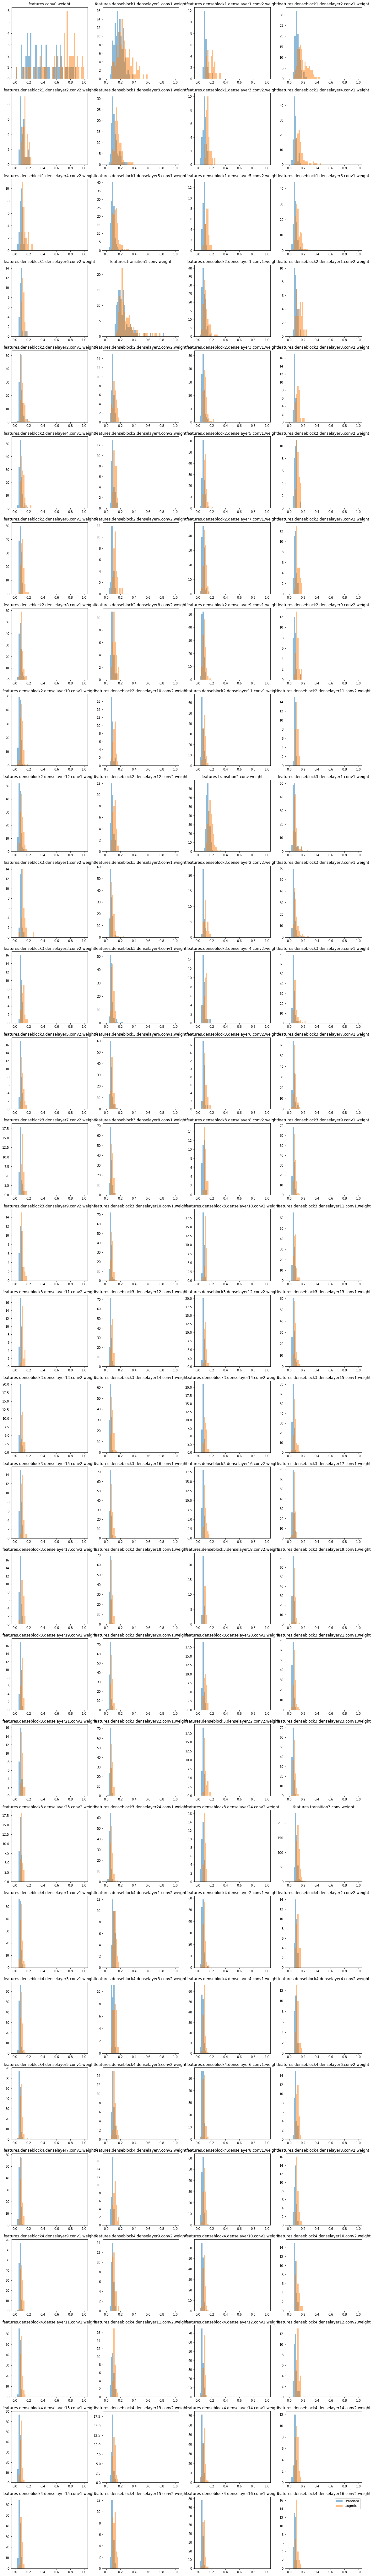

In [4]:
net_plot(param_selector("cifar100_densenet121"), example_densenet(), channel_plot)

Starting with printing standard.
Starting with printing augmix.


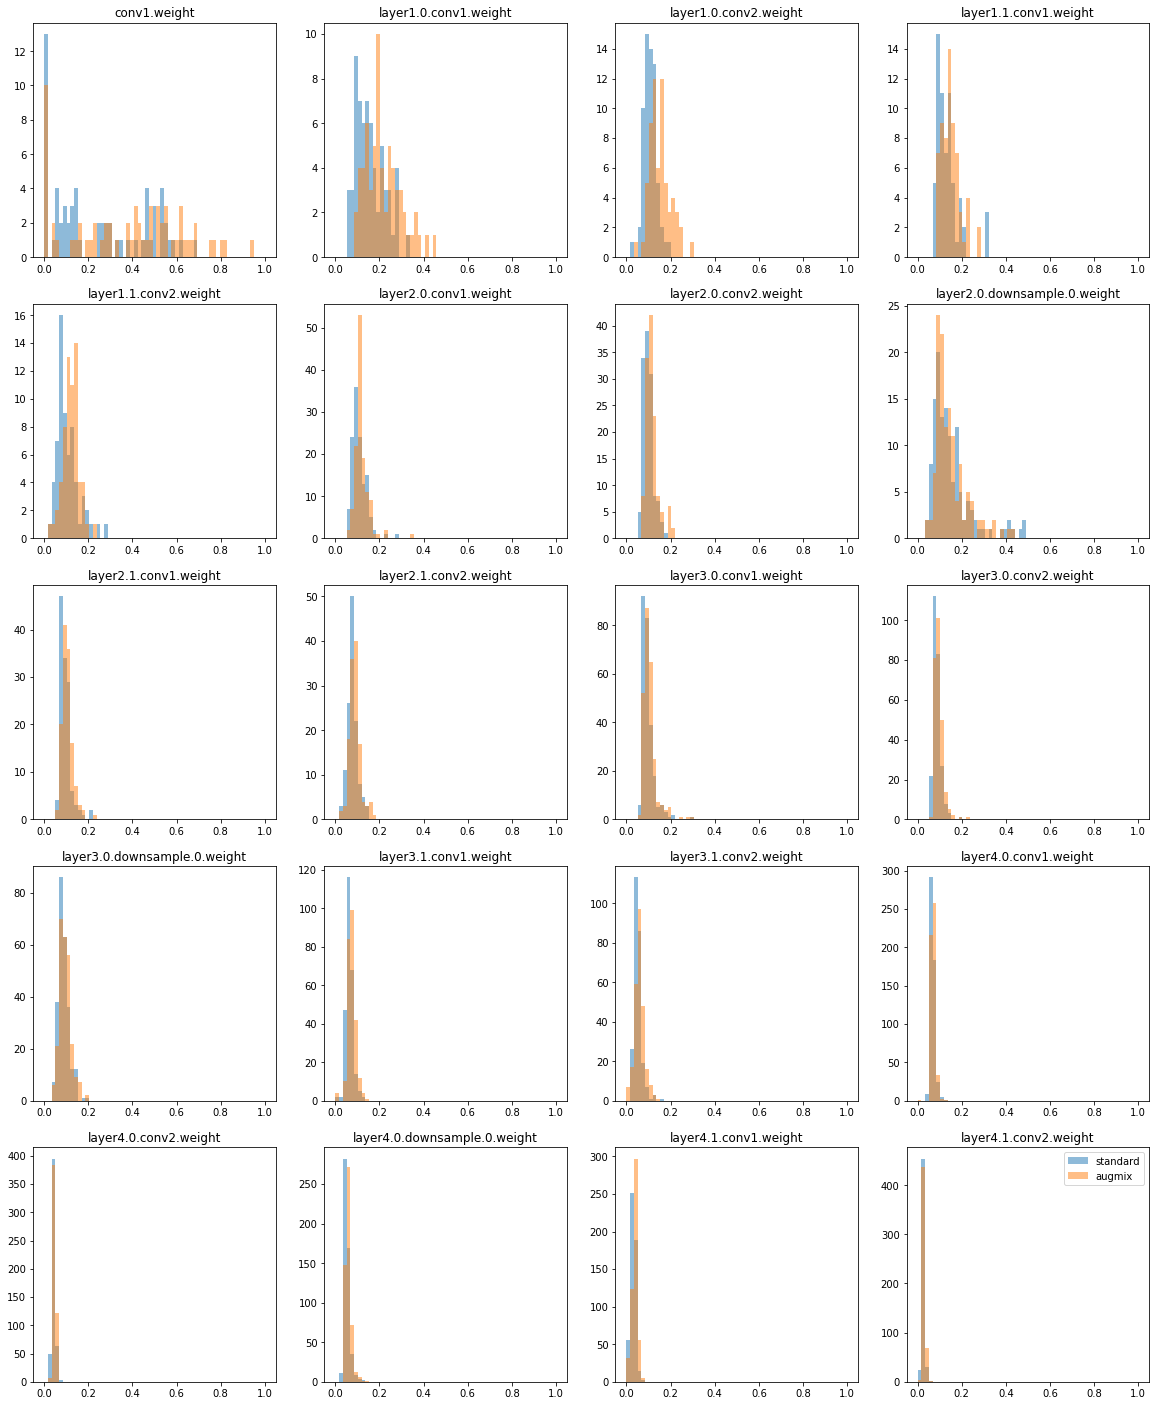

In [104]:
net_plot(param_selector("cifar100_resnet18"), example_aug(1), channel_plot)

Starting with printing standard.
Starting with printing augmix.


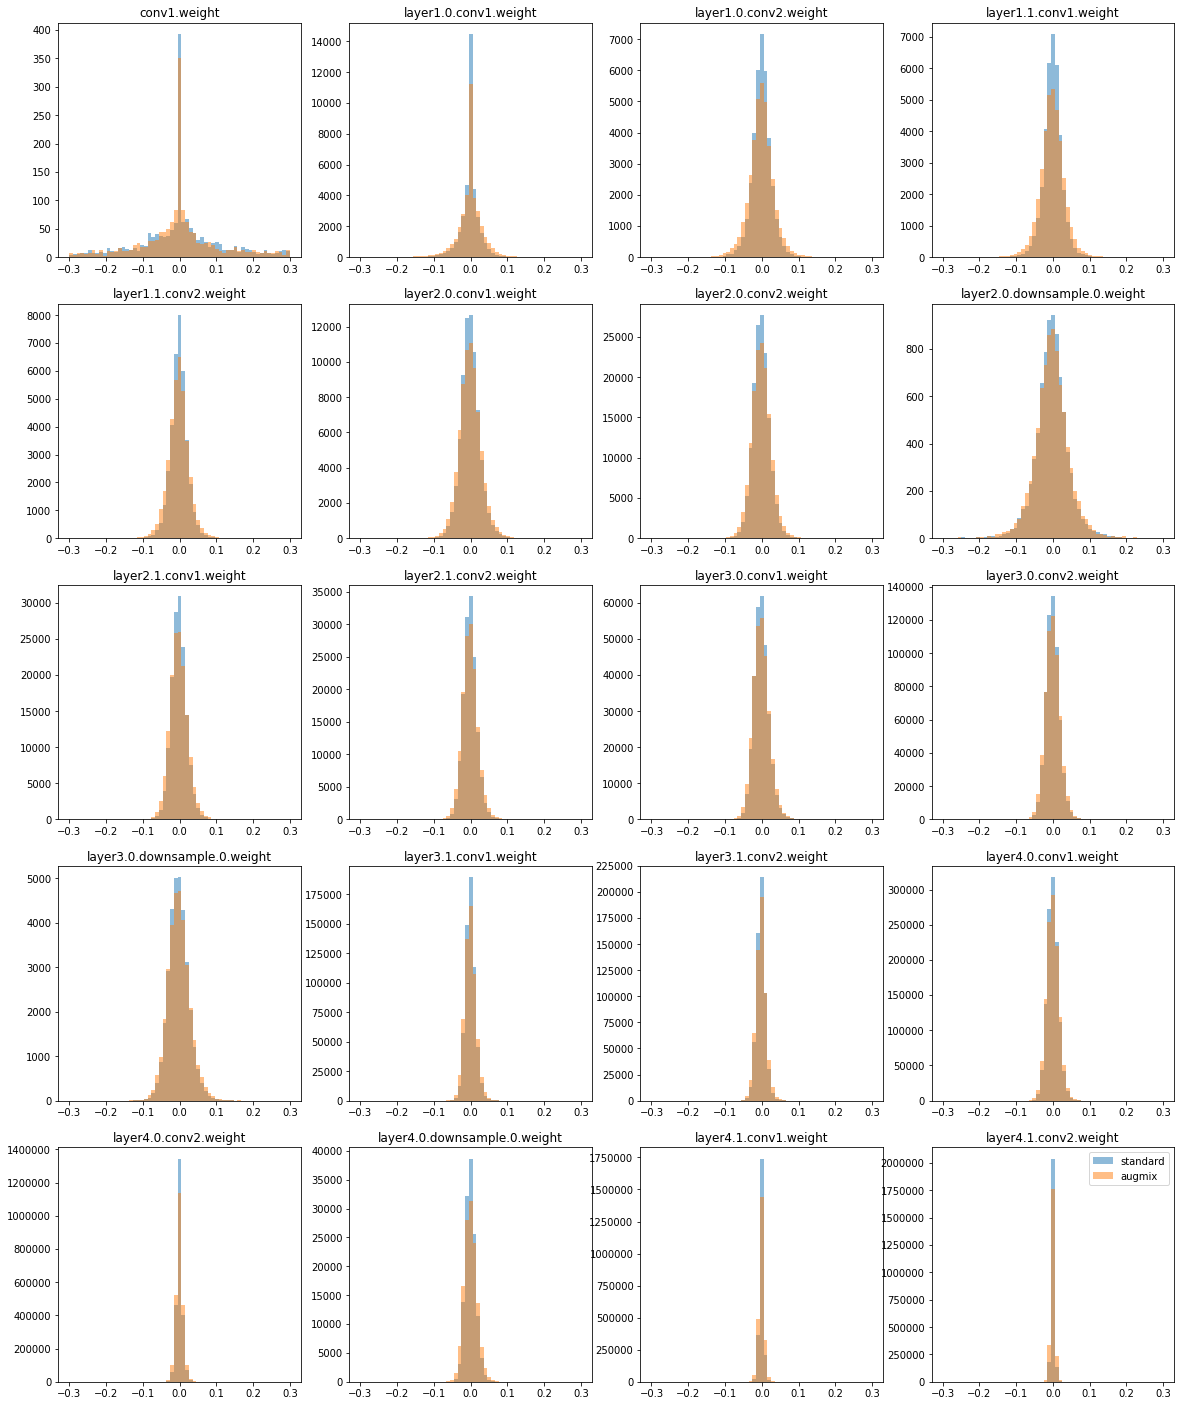

In [133]:
net_plot(param_selector("cifar100_resnet18"), example_aug(1), partial(distr_plot, left=-0.3, right=0.3))

Starting with printing hydra_augmix.
Starting with printing hydra_iid.
Starting with printing l1_channels.


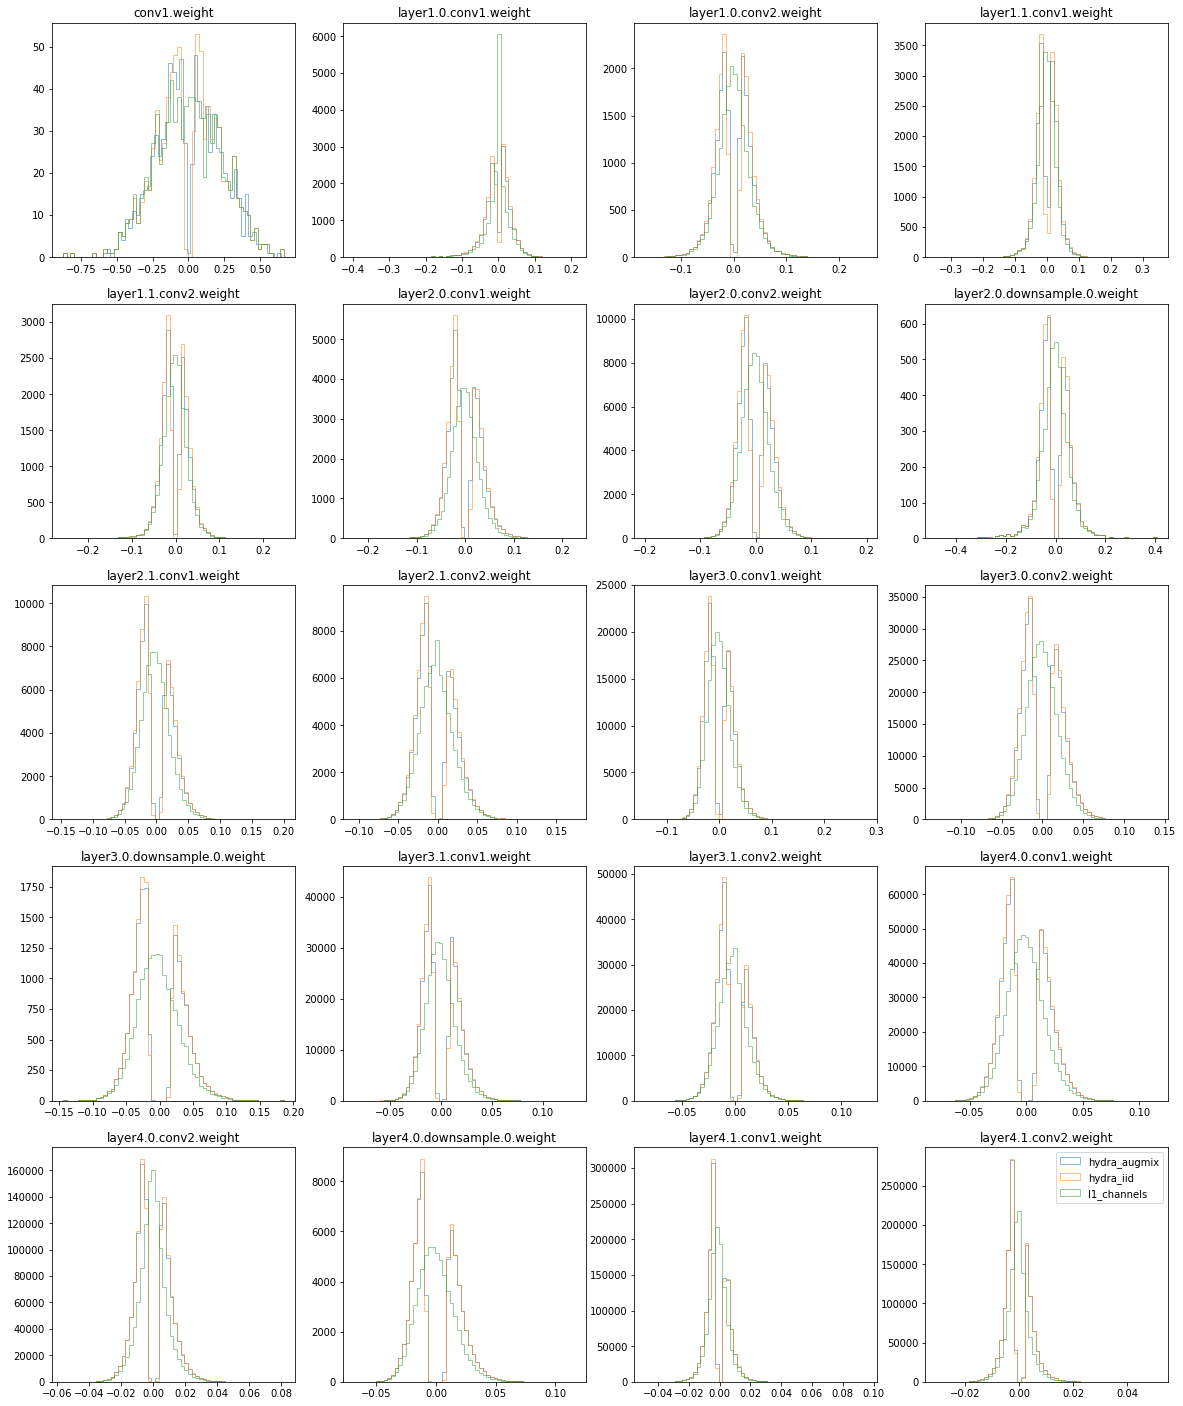

In [113]:
net_plot(param_selector("cifar100_resnet18"), example_prune2(), partial(distr_plot, filter_mask=True))

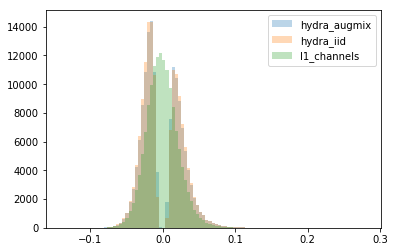

In [95]:
distr_plot(example_prune("layer3.0.conv1.weight"))

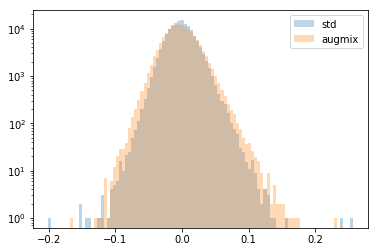

In [125]:
distr_plot(example_aug("layer2.1.conv1.weight", version=2))

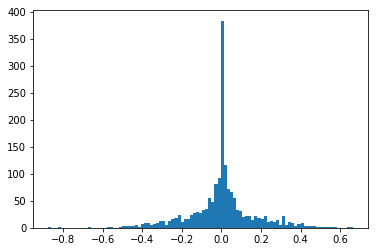

In [54]:
_ = distr_plot([net.conv1.weight.detach().numpy().flatten()], num_bins=100)

In [55]:
net = create_network("cifar100_resnet18")
hydrate(net, ratio=2)
net.load_state_dict(load_state_dict(ckpt_path_hydra))

<All keys matched successfully>

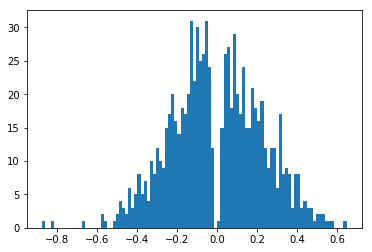

In [56]:
_ = distr_plot([net.conv1.weight.detach().numpy().flatten()], num_bins=100)

In [64]:
net = create_network("cifar100_resnet18")
hydrate(net, ratio=2)
net.load_state_dict(load_state_dict(ckpt_path_hydra_iid))

<All keys matched successfully>

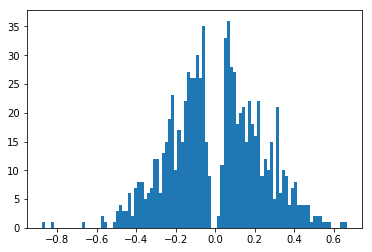

In [65]:
_ = distr_plot([net.conv1.weight.detach().numpy().flatten()], num_bins=100)

In [58]:
net = create_network("cifar100_resnet18", model_path=standard_path)
prune(net, "layer_weight", 2)

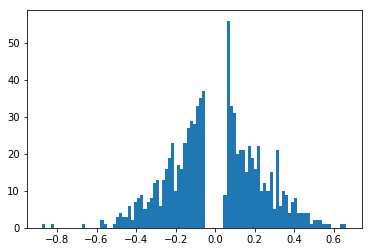

In [59]:
_ = distr_plot([net.conv1.weight.detach().numpy().flatten()], num_bins=100)

In [60]:
net = create_network("cifar100_resnet18", model_path=standard_path)
prune(net, "l1_channels", 2)

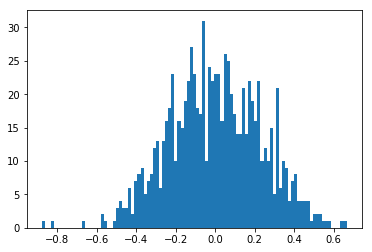

In [62]:
_ = distr_plot([net.conv1.weight.detach().numpy().flatten()], num_bins=100)